# Capítulo 9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import json
%matplotlib inline

A função abaixo recebe um modelo de support vector machine, e plota a fronteira de decisão além dos vetores de suporte.

In [137]:
# support function to plot the decision boundary of svc and highlight the support vectors
def plot_decision_boundary(svc, X, y, h=0.021, pad=0.21):
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.scatter(X[y==-1,0], X[y==-1,1], s=70, c="blue", label=-1)
    plt.scatter(X[y==1,0], X[y==1,1], s=70, c="orange", label=1)
    if 0 in y:
        plt.scatter(X[y==0,0], X[y==0,1], s=70, c="green", label=1)
        
    # highlight the support vectors
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='*', s=21, linewidths=1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

## 9.6.1 Classificador de vetores de suporte

Para ilustrar o funcionamento do classificador de vetores de suporte, vamos gerar dados artificiais, tal como no livro. Serão 20 observações com 2 features, e queremos prever se a classe correspondente de cada observação é 0 ou 1.

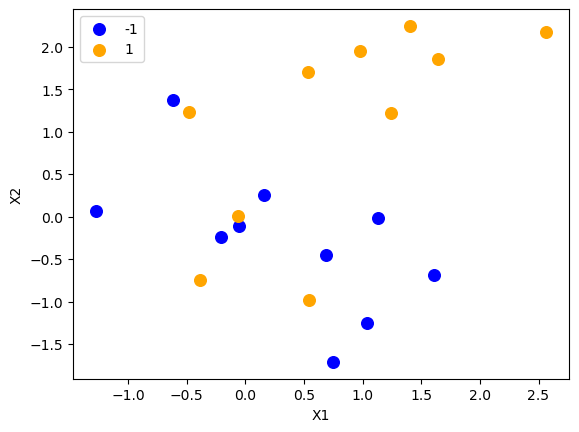

In [138]:
np.random.seed(21)
X = np.random.randn(20, 2)
y = np.repeat([-1,1], 10)
X[y==1] = X[y==1] + 1

plt.scatter(X[y==-1,0], X[y==-1,1], s=70, c="blue", label=-1)
plt.scatter(X[y==1,0], X[y==1,1], s=70, c="orange", label=1)

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

Quais desses pontos são de fato determinantes para o fit de classificador de vetores de suporte (com kernel linear)? 

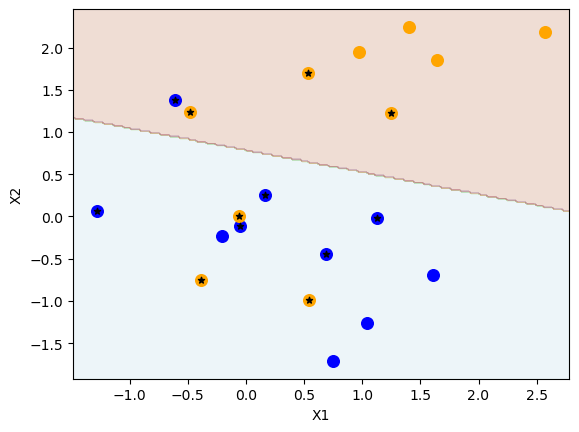

Number of support vectors:  12


In [139]:
svc1 = SVC(C= 10, kernel='linear')
svc1.fit(X, y)

plot_decision_boundary(svc1, X, y)

Os parâmetros do modelo podem ser obtidos via o método `svc.get_params()`.

In [140]:
svc1.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Por exemplo, o que acontece se reduzirmos o custo `C` de 10 para 0.1? Com isso, vamos obter mais vetores de suporte porque a margem do classificador é maior.

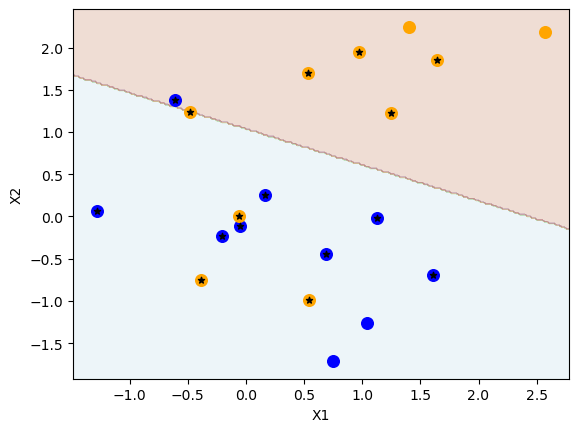

Number of support vectors:  16


In [141]:
svc2 = SVC(C=0.1, kernel='linear')
svc2.fit(X, y)

plot_decision_boundary(svc2, X, y)

Considerando o impacto dessa opção? Como fazer para escolher o melhor valor de `C`? Como já discutimos antes, CV é uma boa opção. Nesse caso, existe a função `GridSearchCV()` que automaticamente nos diz quais dentre alguns candidatos é o melhor valor para o parâmetro.

In [142]:
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X, y)
clf.cv_results_

{'mean_fit_time': array([0.00034699, 0.00032756, 0.0002526 , 0.00037344, 0.00044334,
        0.00054202, 0.00292621]),
 'std_fit_time': array([1.26696010e-04, 1.46672484e-04, 4.94998542e-06, 1.32888196e-04,
        1.49029588e-04, 3.15396930e-04, 2.99157877e-03]),
 'mean_score_time': array([0.00027251, 0.00021996, 0.00018079, 0.0002249 , 0.00019553,
        0.00018635, 0.00018864]),
 'std_score_time': array([1.09168376e-04, 7.30552965e-05, 7.23552270e-07, 6.39028555e-05,
        2.95749478e-05, 1.26698782e-06, 3.73305941e-06]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 5, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 5},
  {'C': 10},
  {'C': 100}],
 'split0_test_score': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'split1_test_score': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'split2_test_score': array([0.5, 0.5, 0

O melhor valor encontrado para o parâmetro pode ser acessado via `clf.best_params_` (esse valor é diferente do livro mas, como o dataset é bem pequeno, é provável que seja por conta dos valores aleatórios usados para gerar o dataset).

In [143]:
clf.best_params_

{'C': 1}

Tendo escolhido o valor de `C`, vamos ver como o modelo se sairia num conjunto de teste. Como definimos o processo gerador de dados, podemos simplesmente criar um novo conjunto de teste.

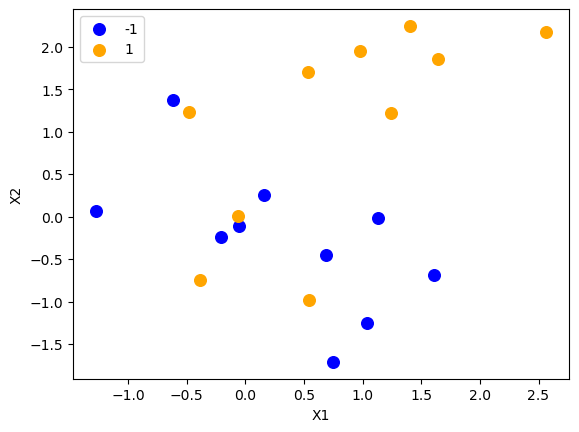

In [144]:
X_test = np.random.randn(20, 2)
y_test = np.repeat([-1,1], 10)
X_test[y_test==1] = X_test[y_test==1] + 1

plt.scatter(X[y==-1,0], X[y==-1,1], s=70, c="blue", label=-1)
plt.scatter(X[y==1,0], X[y==1,1], s=70, c="orange", label=1)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

Treinamos o mesmo modelo que antes, e vamos ver como é a matriz de confusão no conjunto de teste.

In [145]:
# train a model with the optimal parameters
svc3 = SVC(C=1, kernel='linear')
svc3.fit(X, y)

SVC(C=1, kernel='linear')

In [146]:
y_pred = svc3.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svc3.classes_, columns=svc3.classes_)

,-1,1
-1,6,4
1,4,6


Conseguimos 15 acertos e 6 erros. Note que, como os dados que usamos não são linearmente separáveis, não tínhamos como obter 100% de acerto. De fato, vamos agora gerar um conjunto separável e nos certificar da performance do nosso classificador.

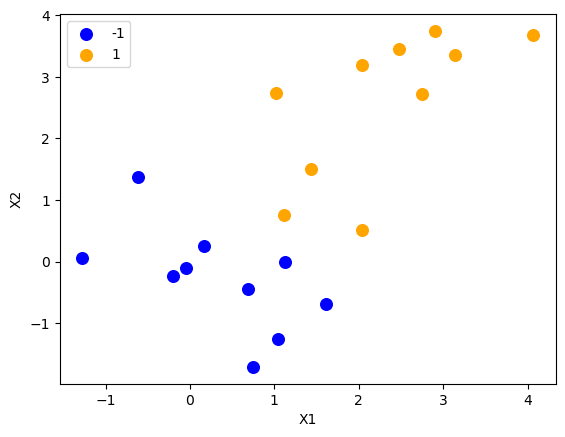

In [147]:
np.random.seed(21)
X = np.random.randn(20, 2)
y = np.repeat([-1,1], 10)
X[y==1] = X[y==1] + 2.5

plt.scatter(X[y==-1,0], X[y==-1,1], s=70, c="blue", label=-1)
plt.scatter(X[y==1,0], X[y==1,1], s=70, c="orange", label=1)
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Vamos também gerar um conjunto de teste seguindo o mesmo procedimento, e de tal maneira que o teste também seja linearmente separável.

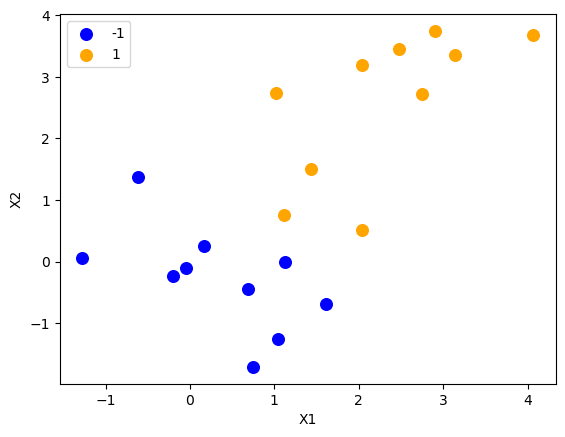

In [148]:
X_test = np.random.randn(20, 2)
y_test = np.repeat([-1,1], 10)
X_test[y_test==1] = X_test[y_test==1] + 2.5

plt.scatter(X[y==-1,0], X[y==-1,1], s=70, c="blue", label=-1)
plt.scatter(X[y==1,0], X[y==1,1], s=70, c="orange", label=1)
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

O resultado de treino (usando `C` alto, já que os dados são separáveis) é o seguinte.

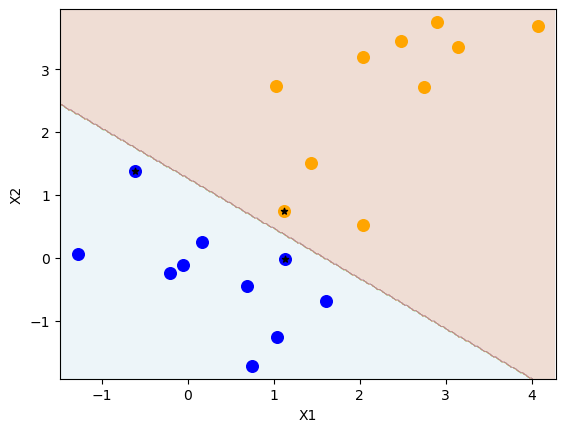

Number of support vectors:  3


In [149]:
svc4 = SVC(C=100, kernel='linear')
svc4.fit(X, y)

plot_decision_boundary(svc4, X, y)

Há apenas três vetores de suporte! E, como imaginaríamos, a performance do classificador sob essas condições ideais é muito boa.

In [150]:
y_pred = svc4.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svc4.classes_, columns=svc4.classes_)

,-1,1
-1,8,2
1,0,10


Podemos visualizar os dados de teste para entender também quem são os dois pontos em que erramos a previsão.

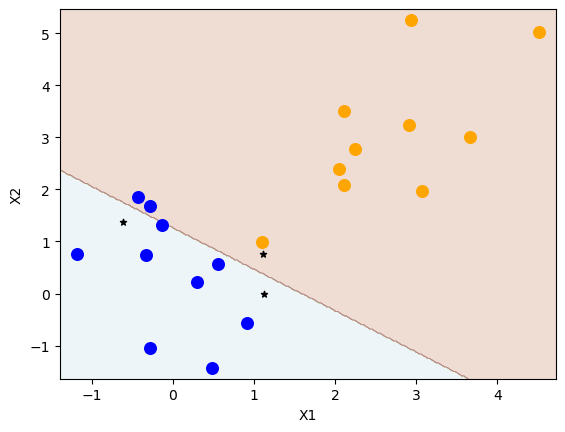

Number of support vectors:  3


In [151]:
plot_decision_boundary(svc4, X_test, y_test)

## 9.6.2 Máquinas de vetores de suporte

Vamos entender como as previsões mudam ao usarmos uma máquina de vetores de suporte.

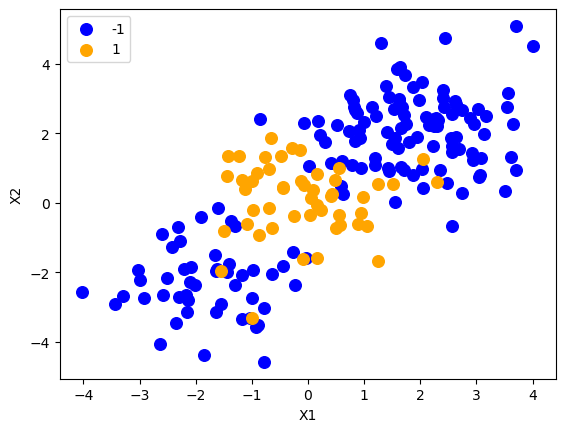

In [152]:
np.random.seed(21)
X = np.random.randn(200,2)
X[:100] = X[:100] + 2
X[101:150] = X[101:150] - 2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

plt.scatter(X[y==-1,0], X[y==-1,1], s=70, c="blue", label=-1)
plt.scatter(X[y==1,0], X[y==1,1], s=70, c="orange", label=1)
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

A única coisa que muda é o kernel: vamos usar um kernel radial, com intensidade `gamma=1`.

In [153]:
svm = SVC(C=1.0, kernel='rbf', gamma=1)
svm.fit(X_train, y_train)

SVC(gamma=1)

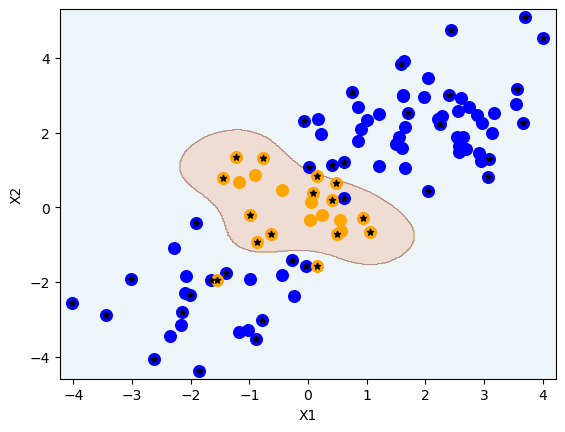

Number of support vectors:  47


In [154]:
plot_decision_boundary(svm, X_train, y_train)

Mesmo tendo um dataset altamente não-separável linearmente, um SVM consegue fazer previsões muito boas.

In [155]:
y_pred = svm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svm.classes_, columns=svm.classes_)

,-1,1
-1,70,3
1,12,15


Podemos inclusive aumentar o parâmetro `C` para ganhar mais flexibilidade no modelo.

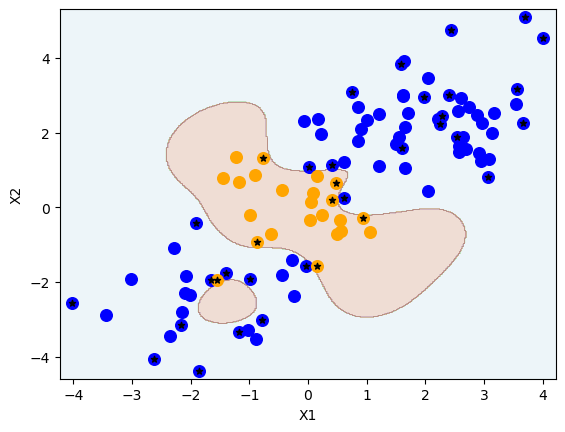

Number of support vectors:  35


In [156]:
# increasing C parameter which increases more flexibility
svm2 = SVC(C=100, kernel='rbf', gamma=1.0)
svm2.fit(X_train, y_train)
plot_decision_boundary(svm2, X_train, y_train)

Note que temos menos vetores de suporte, mas a existência de uma segunda ilha parece indicar algu nível de overfitting. Para investigar essa possibilidade, vamos gerar um conjunto de teste e olhar para a acurácia do estimador.

In [157]:
y_pred = svm2.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svm2.classes_, columns=svm2.classes_)

,-1,1
-1,63,10
1,13,14


De fato, fomos de 15 erros para 23. Como antes, podemos usar CV para escolher o valor ótimo.

In [158]:
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
                     'gamma': [0.5, 1,2,3,4]}]
clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([0.00054212, 0.00049951, 0.00052838, 0.00054255, 0.00048788,
        0.00034802, 0.00037236, 0.00042999, 0.00043316, 0.00044293,
        0.00033205, 0.00037694, 0.00046513, 0.00047688, 0.0004849 ,
        0.00032024, 0.00036631, 0.00045733, 0.00048583, 0.00056491,
        0.00036018, 0.00047617, 0.00050018, 0.00048425, 0.00055602]),
 'std_fit_time': array([1.17926119e-04, 1.34791710e-05, 9.16520216e-06, 4.66375019e-06,
        7.73935536e-05, 4.20056730e-06, 5.60440894e-06, 5.56210923e-05,
        4.21778572e-06, 3.56322130e-06, 9.84703368e-06, 1.96176625e-05,
        2.84311431e-05, 1.41777087e-05, 1.94730628e-05, 8.57365940e-06,
        1.08380586e-05, 1.63318641e-05, 6.61846712e-06, 9.99654274e-05,
        3.77208106e-05, 1.19634100e-04, 6.52362596e-05, 8.95797332e-06,
        1.12857365e-04]),
 'mean_score_time': array([0.000313  , 0.00030031, 0.00030894, 0.00030608, 0.00027845,
        0.00021904, 0.00023184, 0.00023613, 0.00023549, 0.00025356,
        0.00

In [159]:
clf.best_params_

{'C': 1, 'gamma': 0.5}

As escolhas ótimas segundo CV foram `C=1` e `gamma=0.5`, e a nossa matriz de confusão tem 15 erros de teste, apenas, indicando uma acurácia de 85/100=85%.

In [160]:
confusion_matrix(y_test, clf.best_estimator_.predict(X_test))

array([[69,  4],
       [11, 16]])

In [161]:
clf.best_estimator_.score(X_test, y_test)

0.85

## 9.6.3 ROC Curves

Como discutimos antes, uma boa maneira de entender a performance de um estimador é via a curva ROC. Essa curva coloca no eixo-x a taxa de falsos positivos e no eixo-y a taxa de verdadeiros positivos, de tal maneira que quanto mais perto do canto superior esquerdo for a curva melhor. A curva é construída mudando o threshold para prever uma observação como -1 ou 1. Na medida em que comparar números é mais conveniente, frequentemente olhamos para a área sob a curva, de modo que quanto mais perto de 1, melhor.

Vamos olhar para um modelo radial com `gamma=2` e outro mais flexível com `gamma=50`.

In [162]:
svm3 = SVC(C=1, kernel='rbf', gamma=2)
svm3.fit(X_train, y_train)

svm4 = SVC(C=1, kernel='rbf', gamma=50)
svm4.fit(X_train, y_train)

y_train_score3 = svm3.decision_function(X_train)
y_train_score4 = svm4.decision_function(X_train)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_train_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_train, y_train_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

print(f"AUC de svm3 (treino): {roc_auc3}")
print(f"AUC de svm4 (treino): {roc_auc4}")

AUC de svm3 (treino): 0.9960474308300395
AUC de svm4 (treino): 1.0


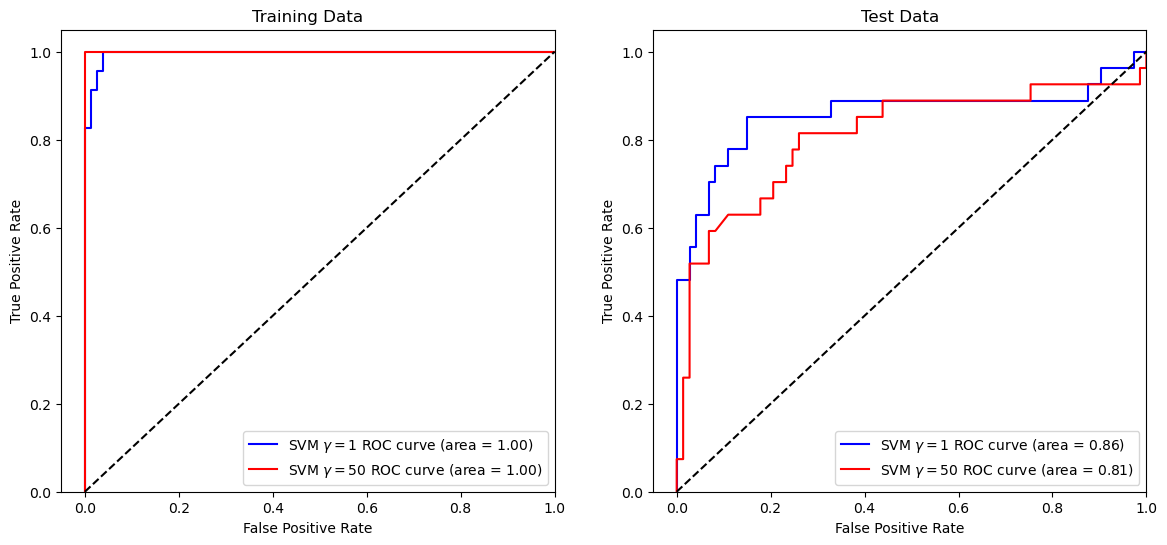

In [163]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax1.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax1.set_title('Training Data')

y_test_score3 = svm3.decision_function(X_test)
y_test_score4 = svm4.decision_function(X_test)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_test, y_test_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_test, y_test_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

ax2.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax2.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

Os plots acima indicam que de fato há um overfitting significativo com `gamma=50` (como naturalmente esperaríamos de um modelo com AUC de treino 1, ou seja, que não comete erro algum).

## 9.6.4 SVM com múltiplas classes

O código que usamos antes também generaliza para prever mais de uma classe. Vamos mostrar um exemplo adicionando uma terceira classe ao exemplo anterior.

Text(0, 0.5, 'XX2')

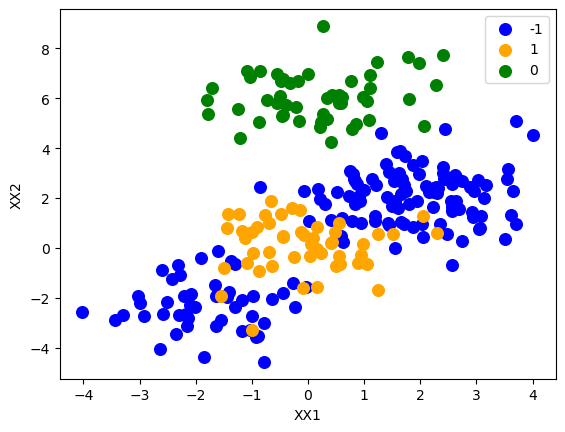

In [168]:
np.random.seed(21)
X = np.random.randn(200,2)
X[:100] = X[:100] + 2
X[101:150] = X[101:150] - 2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

XX = np.vstack([X, np.random.randn(50,2)])
yy = np.hstack([y, np.repeat(0,50)])
XX[yy==0, 1] = XX[yy==0, 1] + 6

plt.scatter(XX[yy==-1,0], XX[yy==-1,1], s=70, c="blue", label=-1)
plt.scatter(XX[yy==1,0], XX[yy==1,1], s=70, c="orange", label=1)
plt.scatter(XX[yy==0,0], XX[yy==0,1], s=70, c="green", label=0)
plt.legend()
plt.xlabel('XX1')
plt.ylabel('XX2')

As previsões do modelo continuam boas (o que poderia ser esperado, considerando que a nova classe continua sendo facilmente separável).

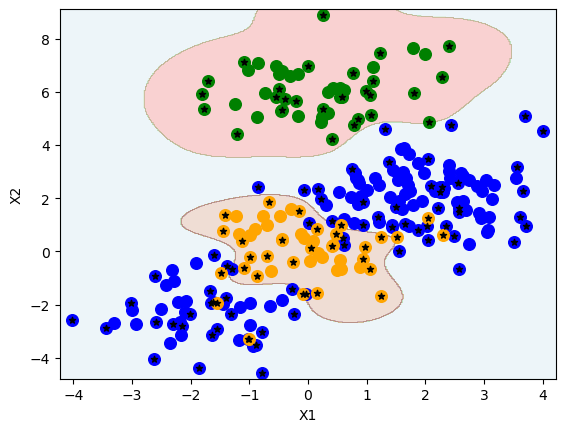

Number of support vectors:  123


In [169]:
svm5 = SVC(C=10, kernel='rbf', gamma=1)
svm5.fit(XX, yy)
plot_decision_boundary(svm5, XX, yy)

## 9.6.5 Application to Gene Expression Data

Vamos aplicar SVM para um dataset real. Especificamos, vamos olhar para o dataset `Khan`, que contém informações de amostras de tecidos referentes a pacientes com quatro tipos de tumores.

In [227]:
X_train = np.array(pd.read_csv('../data/Khan-xtrain.csv', index_col=0))
y_train = np.array(pd.read_csv('../data/Khan-ytrain.csv', index_col=0)).flatten()
X_test = np.array(pd.read_csv('../data/Khan-xtest.csv', index_col=0))
y_test = np.array(pd.read_csv('../data/Khan-ytest.csv', index_col=0)).flatten()

In [223]:
y_train

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1])

Há quatro classes diferentes nos dados:

In [228]:
np.unique(y_train)

array([1, 2, 3, 4])

Treinamos um SVM como antes, e vamos usar `C=10`, com kernel linear. 

In [229]:
svm6 = SVC(C = 10, kernel='linear')
svm6.fit(X_train, y_train)

SVC(C=10, kernel='linear')

Estamos interessados na acurácia de teste do modelo, mas para efeitos de overfitting vamos olhar também para a acurácia de treino.

In [230]:
print('train accuracy', svm6.score(X_train, y_train))
y_pred = svm6.predict(X_test)
print('test accuracy', svm6.score(X_test, y_test))

train accuracy 1.0
test accuracy 0.9


Como temos muitas features e poucas classes, o modelo consegue encontrar hiperplanos que separam bem os dados. No caso de treino, a separação é perfeita, mas mesmo no caso de teste a separação continua sendo muito boa.

A situação é um pouco pior com o kernel radial.

In [236]:
svm6 = SVC(C = 10, kernel='rbf')
svm6.fit(X_train, y_train)
print('train accuracy', svm6.score(X_train, y_train))
y_pred = svm6.predict(X_test)
print('test accuracy', svm6.score(X_test, y_test))

train accuracy 1.0
test accuracy 0.8
